# {Title of project}

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import re
import numpy as np
from sklearn import manifold, datasets
from adjustText import adjust_text
import math

In [2]:
def create_pickle_initial(): # Call this function to create the required pickle file
    df = pd.read_csv('data/en.openfoodfacts.org.products.csv', '\t')

    interest = df.product_name.dropna().index.intersection(df.ingredients_text.dropna().index)
    interest = interest.intersection(df[df.countries_en == 'France'].index)

    df1 = df.iloc[interest]

    df1[['product_name', 'ingredients_text', 'allergens']].to_pickle('french_products_ingredients.pkl')
    
    columns_grams = list(filter(lambda c: '_100g' in c, df.columns.tolist()))
    columns_grams.insert(0, 'product_name')
    df2 = df[df.product_name.notnull()]
    df2[columns_grams].to_pickle('products_100g.pkl')

In [3]:
# Uncomment this line to generate the pickle file
#create_pickle_initial()

In [4]:
df = pd.read_pickle('french_products_ingredients.pkl')

In [5]:
print(len(df))
df.head(5)

183980


,product_name,ingredients_text,allergens
14,Solène céréales poulet,"antioxydant : érythorbate de sodium, colorant ...","en:eggs,en:mustard"
21,Crème dessert chocolat,"Lait entier, sucre, amidon de maïs, cacao, Aga...",NaN
28,Baguette Poitevin,"baguette Poite vin Pain baguette 50,6%: farine...","BLÉ, GLUTEN, BLE, FROMAGE, LAIT, LAIT, LAIT, L..."
37,Suedois saumon,"Paln suédois 42,6%: farine de BLÉ, eau, farine...","BLÉ, SEIGLE, BLÉ, SEIGLE, SAUMON, FROMAGE"
41,Salade shaker taboulé,"Taboulé 76,2%, légumes 12%, huile de colza, se...",NaN


In [6]:
# Pipeline to extract the ingredients - can be improved but already works quite well
ingredients = df.ingredients_text.apply(lambda s: list(map(lambda t: t.strip(), re.sub("\(.+?\)", '', s.lower()).split(','))))
ingredients = ingredients.explode()
exploded = ingredients.str.lower().str.replace("^.*?[0-9]+[^ ]*? ", '').str.replace(" [0-9].*$", '').str.replace("([0-9]*%|\.|[_\(\)\:\*\[\]])", '').str.replace('^[0-9]+$', '').str.strip()
exploded = exploded.str.replace('œ', 'oe').str.replace('[éèêë]', 'e').str.replace('[àâä]', 'a').str.replace('[îï]', 'i').str.replace('[uûùü]', 'u').str.replace('[ôö]', 'o')
exploded = exploded[exploded.apply(lambda s: len(s) > 0)]

by_count = pd.Series(exploded).value_counts()

In [7]:
len(by_count)

315929

In [8]:
by_count.head(30)

sel                           68812
sucre                         50548
eau                           45720
farine de ble                 17609
huile de tournesol            12041
dextrose                      11223
aromes                        10953
huile de colza                10111
sirop de glucose              10002
arome                          9568
ail                            9049
epices                         8091
arome naturel                  7395
poivre                         7313
beurre                         6900
aromes naturels                6376
beurre de cacao                6307
levure                         6219
oignons                        5476
oeufs                          5031
acidifiant  acide citrique     5018
lait ecreme en poudre          4968
pate de cacao                  4888
lactose                        4538
ferments lactiques             4391
sucre de canne                 4379
creme                          4325
persil                      

In [9]:
# Number of ingredients (= dimensions) to consider
n_dimensions = 1000
# Number of rows (= datapoints) to consider at most
n_rows = 100000

# Minimum number of ingredients appearing in the list
min_ingredients = 3

relevant = by_count.head(n_dimensions).index.tolist()
products = exploded.iloc[df.head(n_rows).index]

values = {}
for col in relevant:
    values[col] = products.apply(lambda s: 1 if s == col else 0).groupby(products.index).max()
matrix = pd.DataFrame(values)

matrix = matrix[matrix.sum(axis=1) >= min_ingredients]

In [10]:
len(matrix)

8816

In [11]:
matrix.head(5)

,sel,sucre,eau,farine de ble,huile de tournesol,dextrose,aromes,huile de colza,sirop de glucose,arome,...,cerise,conservateur e282,tournesol,cereales contenant du gluten,colour,lactate de calcium,graines de lin brun,gelifiant pectines de fruits,macis,lait concentre ecreme
515,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
549,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
596,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
613,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
def write_pickle_tsne():
    X = matrix.head(10000)
    
    n_components = 2 # Number of dimensions to reduce to
    perplexity = 100 # t-SNE parameter (the higher the better the result, but also the more expensive)
    tsne = manifold.TSNE(n_components=n_components, init='random', random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    
    X.to_pickle('products_ingredients_matrix.pkl')
    np.save('products_ingredients_tsne.npy', Y)

In [13]:
# Uncomment this line to generate the pickle file
#write_pickle_tsne()

In [14]:
X = pd.read_pickle('products_ingredients_matrix.pkl')
Y = np.load('products_ingredients_tsne.npy')

In [15]:
def highlight(f):
    x, y = Y.T
    names = df.product_name[X.index]
    names_list = names.tolist()
    colors = names.apply(lambda s: 'red' if f(s) else 'lightgray').tolist()
    
    fig, ax = plt.subplots(figsize=(15,15))

    sc = plt.scatter(x, y, c=colors, s=5)
    
    texts = [plt.text(x[i], y[i], names_list[i], fontsize=7) for i in np.random.choice(len(X), 70)]
    adjust_text(texts)

    plt.show()

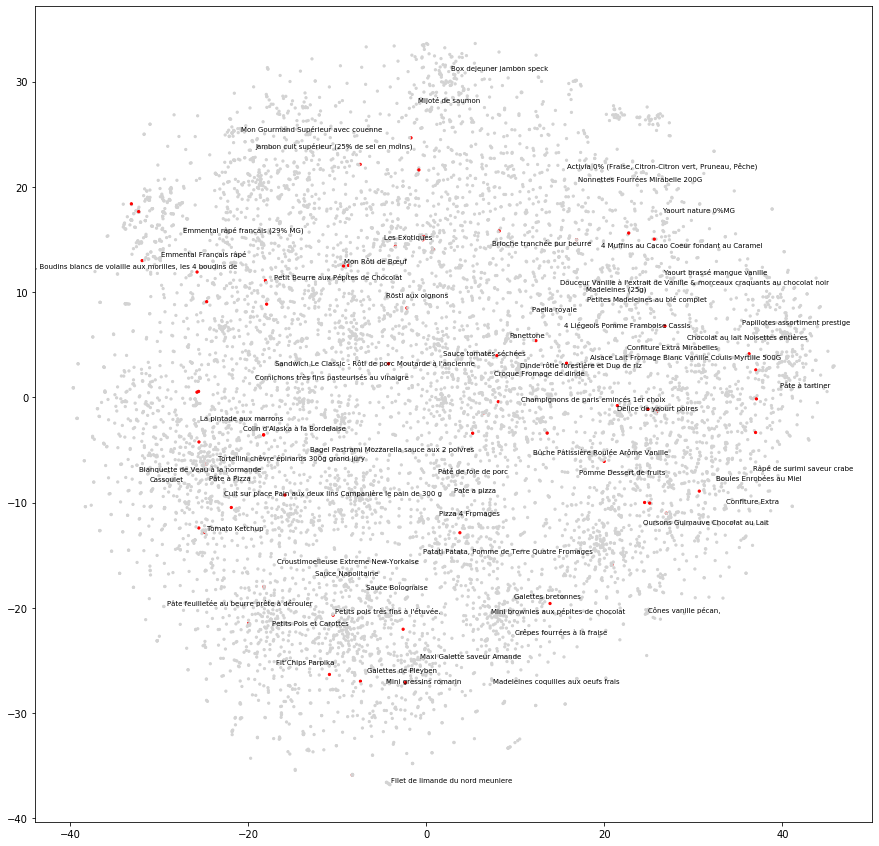

In [16]:
highlight(lambda s: '.' in s.lower())

In [17]:
def highlight2(cols, title):
    x, y = Y.T
    
    def exists_col(r):
        for c in cols:
            if r[c] == 1:
                return True
        return False
    
    colors = matrix.loc[X.index.intersection(matrix.index)].apply(lambda r: 'red' if exists_col(r) else 'lightgray', axis=1).tolist()
    
    fig, ax = plt.subplots(figsize=(15,15))

    plt.axis('off')
    
    sc = plt.scatter(x, y, c=colors, s=5)
    
    texts = [plt.text(x[i], y[i], names_list[i], fontsize=7) for i in np.random.choice(len(X), 0)]
    adjust_text(texts)

    plt.title(title)
    
    plt.show()

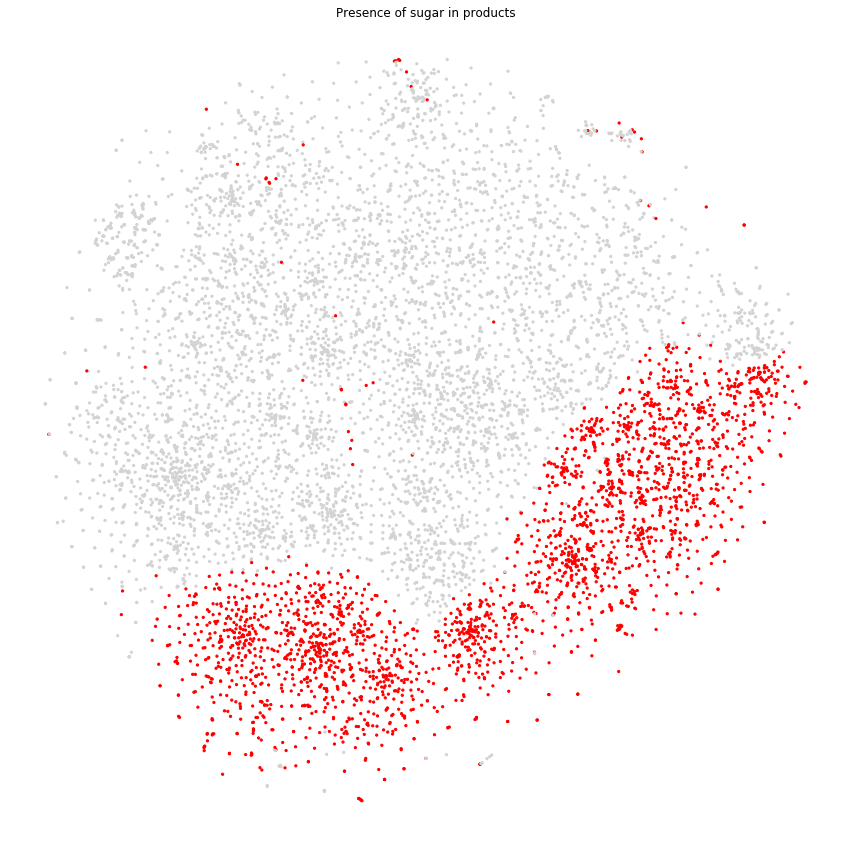

In [18]:
highlight2(['sucre'], 'Presence of sugar in products')

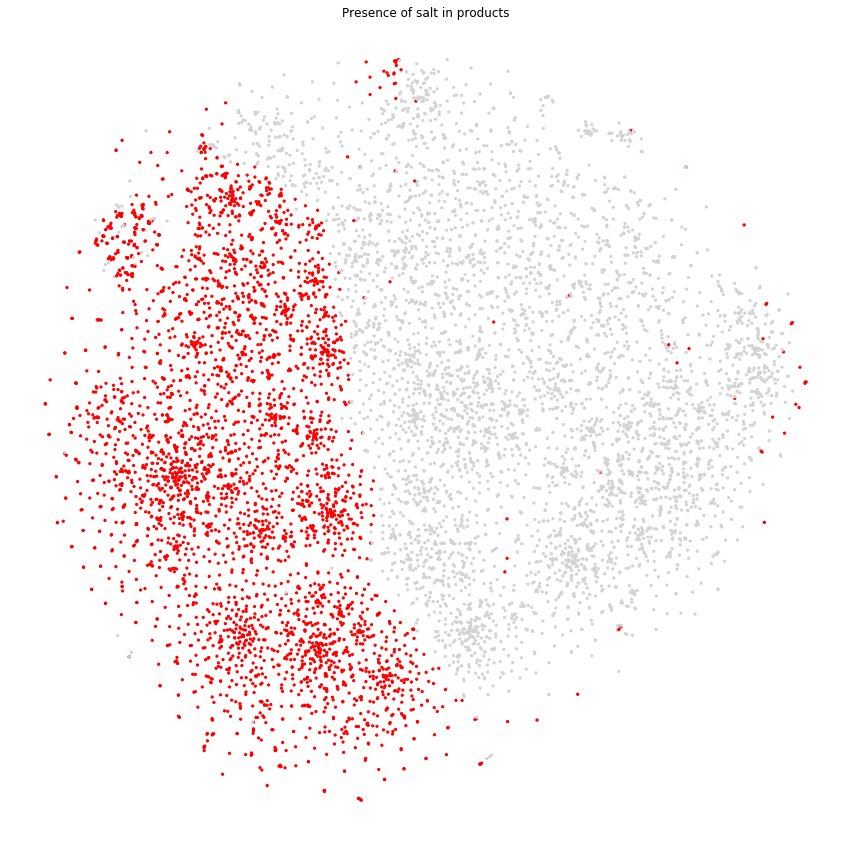

In [19]:
highlight2(['sel'], 'Presence of salt in products')

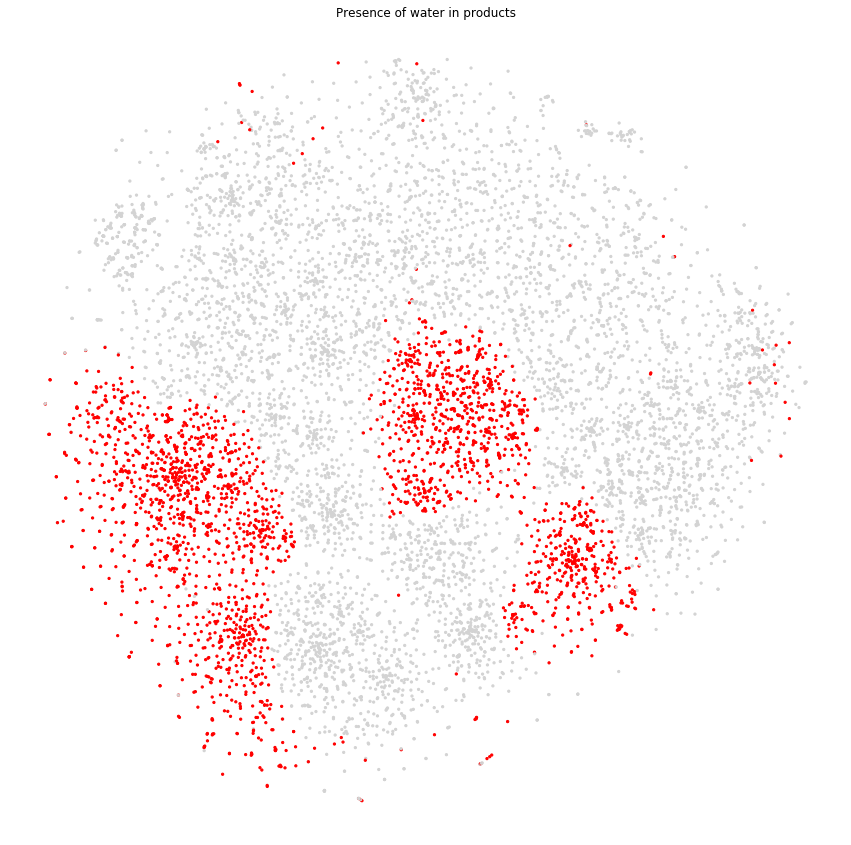

In [20]:
highlight2(['eau'], 'Presence of water in products')

In [21]:
by_count.head(50).index.tolist()

['sel',
 'sucre',
 'eau',
 'farine de ble',
 'huile de tournesol',
 'dextrose',
 'aromes',
 'huile de colza',
 'sirop de glucose',
 'arome',
 'ail',
 'epices',
 'arome naturel',
 'poivre',
 'beurre',
 'aromes naturels',
 'beurre de cacao',
 'levure',
 'oignons',
 'oeufs',
 'acidifiant  acide citrique',
 'lait ecreme en poudre',
 'pate de cacao',
 'lactose',
 'ferments lactiques',
 'sucre de canne',
 'creme',
 'persil',
 'lait',
 'proteines de lait',
 'oignon',
 "vinaigre d'alcool",
 'emulsifiant',
 'sirop de glucose-fructose',
 'amidon de mais',
 'gluten de ble',
 'moutarde',
 "huile d'olive vierge extra",
 'soja',
 'creme fraiche',
 'poudre de lait ecreme',
 'carottes',
 'arome naturel de vanille',
 'basilic',
 'oeuf',
 'viande de porc',
 'celeri',
 'miel',
 'antioxydant  acide ascorbique',
 'amidon de ble']

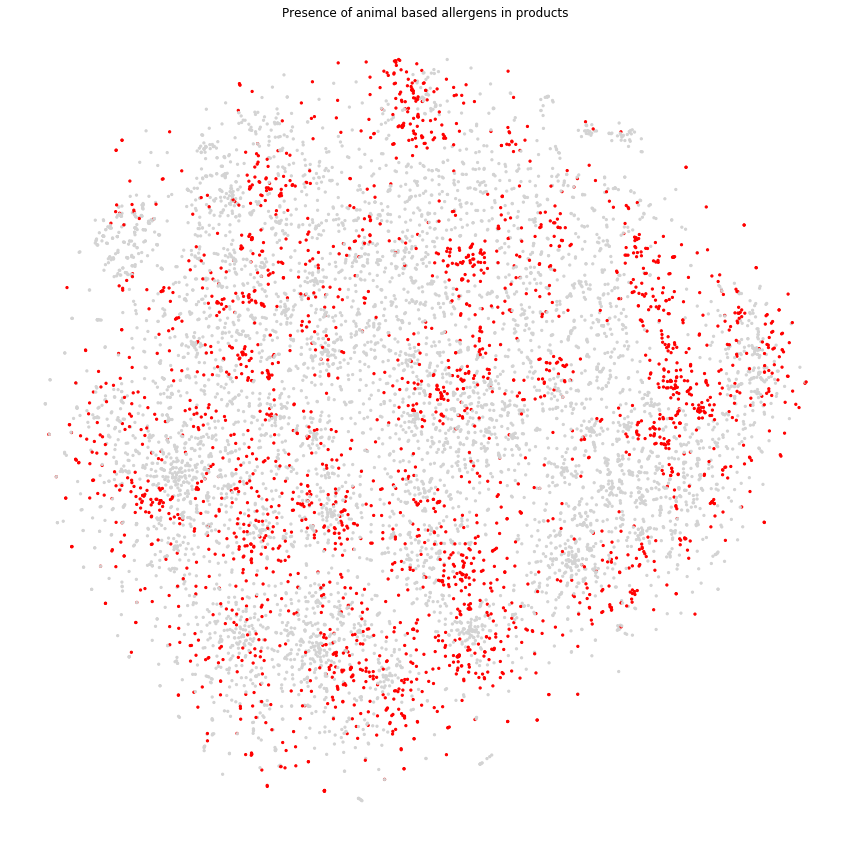

In [22]:
highlight2(['beurre', 'oeufs', 'lait ecreme en poudre', 'lactose', 'creme', 'lait', 'proteines de lait', 'creme fraiche', 'poudre de lait ecreme', 'oeuf', 'beurre concentre', 'lait entier', 'lait entier en poudre', 'oeufs frais'], 'Presence of animal based allergens in products')

In [23]:
def highlight3():
    x, y = Y.T
    colors = df.loc[X.index].apply(lambda s: 'red' if pd.isnull(s.allergens) else 'lightgray', axis=1).tolist()
    
    fig, ax = plt.subplots(figsize=(15,15))

    sc = plt.scatter(x, y, c=colors, s=5)

    plt.show()

In [24]:
def highlight4():
    x, y = Y.T
    loc = df.loc[X.index]

    r1 = []
    r2 = []
    for i, index in enumerate(X.index):
        is_allergen = pd.isnull(df.allergens.loc[index])
        v = Y[i]
        if is_allergen:
            r1.append(v)
        else:
            r2.append(v)
    
    r1 = np.array(r1)
    r2 = np.array(r2)
    
    fig, ax = plt.subplots(figsize=(15,15))

    x1, y1 = r1.T
    x2, y2 = r2.T
    
    ax = sns.kdeplot(x1, y1, cmap="Reds", shade=True, shade_lowest=False, alpha=0.5)
    ax = sns.kdeplot(x2, y2, cmap="Blues", shade=True, shade_lowest=False, alpha=0.5)


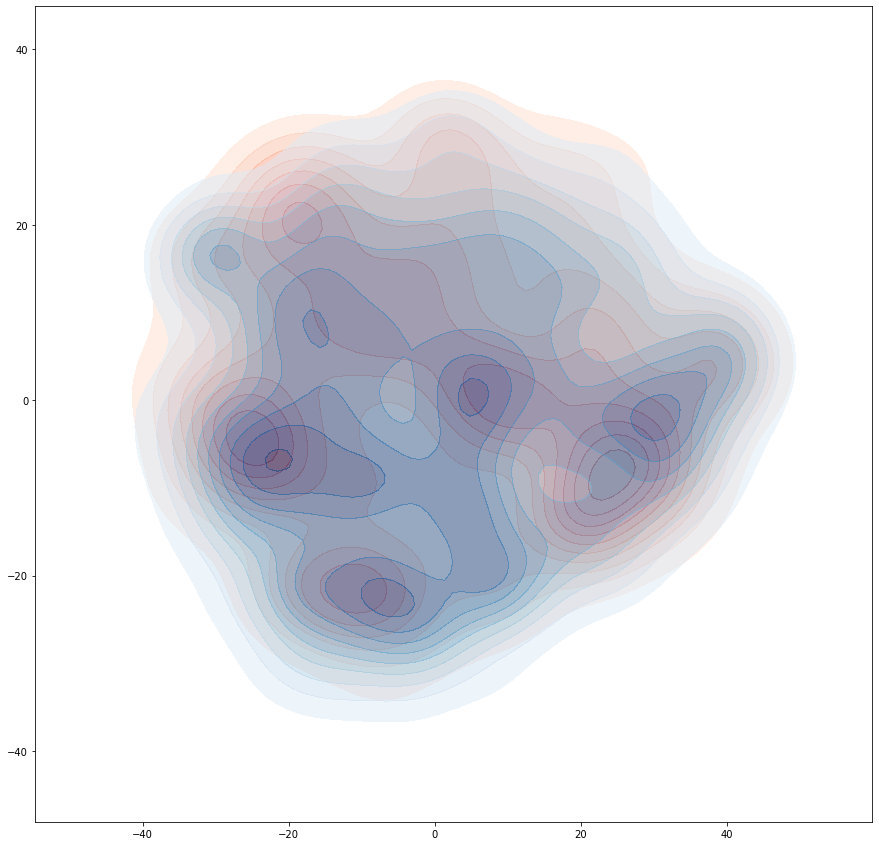

In [25]:
highlight4() # Plot fail!

In [26]:
# Size of the correlation matrix
n_correlations = 20

cmatrix = np.zeros((n_correlations, n_correlations))
columns = matrix.columns.tolist()[:n_correlations]

# https://en.wikipedia.org/wiki/Phi_coefficient
def phi_corr(n):
    top = n[1][1] * n[0][0] - n[1][0] * n[0][1]
    bot = math.sqrt((n[1][0] + n[1][1]) * (n[0][0] + n[0][1]) \
                    * (n[0][0] + n[1][0]) * (n[0][1] + n[1][1]))
    return top / bot
    
for i in range(n_correlations):
    a = columns[i]
    for j in range(i):
        b = columns[j]
        m = matrix[[a, b]]
        vs = [0, 1]
        result = np.zeros((len(vs), len(vs)))
        for x in vs:
            for y in vs:
                result[x][y] = len(m[(m[a] == x) & (m[b] == y)])

        cmatrix[i][j] = phi_corr(result)

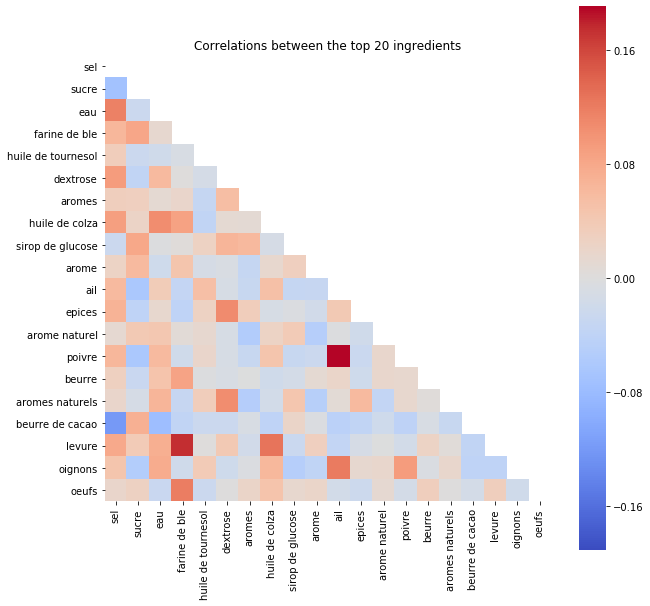

In [27]:
mask = np.zeros_like(cmatrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

m = np.max(np.abs(cmatrix))

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Correlations between the top %s ingredients' % n_correlations)
sns.heatmap(cmatrix, ax=ax, square=True, mask=mask, vmin=-m, vmax=m, xticklabels=columns, yticklabels=columns, cmap='coolwarm');

---

In [28]:
dfg = pd.read_pickle('products_100g.pkl')

In [29]:
dfg.head(5)

,product_name,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,Vitória crackers,1569.0,NaN,7.0,3.08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Cacao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sfiudwx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Sauce Sweety chili 0%,88.0,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Mini coco,251.0,NaN,3.0,1.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Columns per number of not empty rows
dfg.drop('product_name', axis=1).count().sort_values(ascending=False).head(25)

energy_100g                             803585
proteins_100g                           800841
fat_100g                                798941
carbohydrates_100g                      798889
sugars_100g                             784961
salt_100g                               781070
sodium_100g                             781019
saturated-fat_100g                      769426
fiber_100g                              299852
nutrition-score-fr_100g                 284225
nutrition-score-uk_100g                 284225
calcium_100g                            145820
cholesterol_100g                        144980
trans-fat_100g                          144185
iron_100g                               142548
vitamin-c_100g                          142435
vitamin-a_100g                          138899
potassium_100g                           26090
polyunsaturated-fat_100g                 24319
monounsaturated-fat_100g                 24270
vitamin-pp_100g                          12620
vitamin-b1_10

In [31]:
sub = dfg.head(10000)

In [32]:
sub = sub[sub.apply(lambda r: r.fat_100g < 100 and r.sugars_100g < 100 and r.energy_100g < 4000 and r.salt_100g < 100, axis=1)]

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


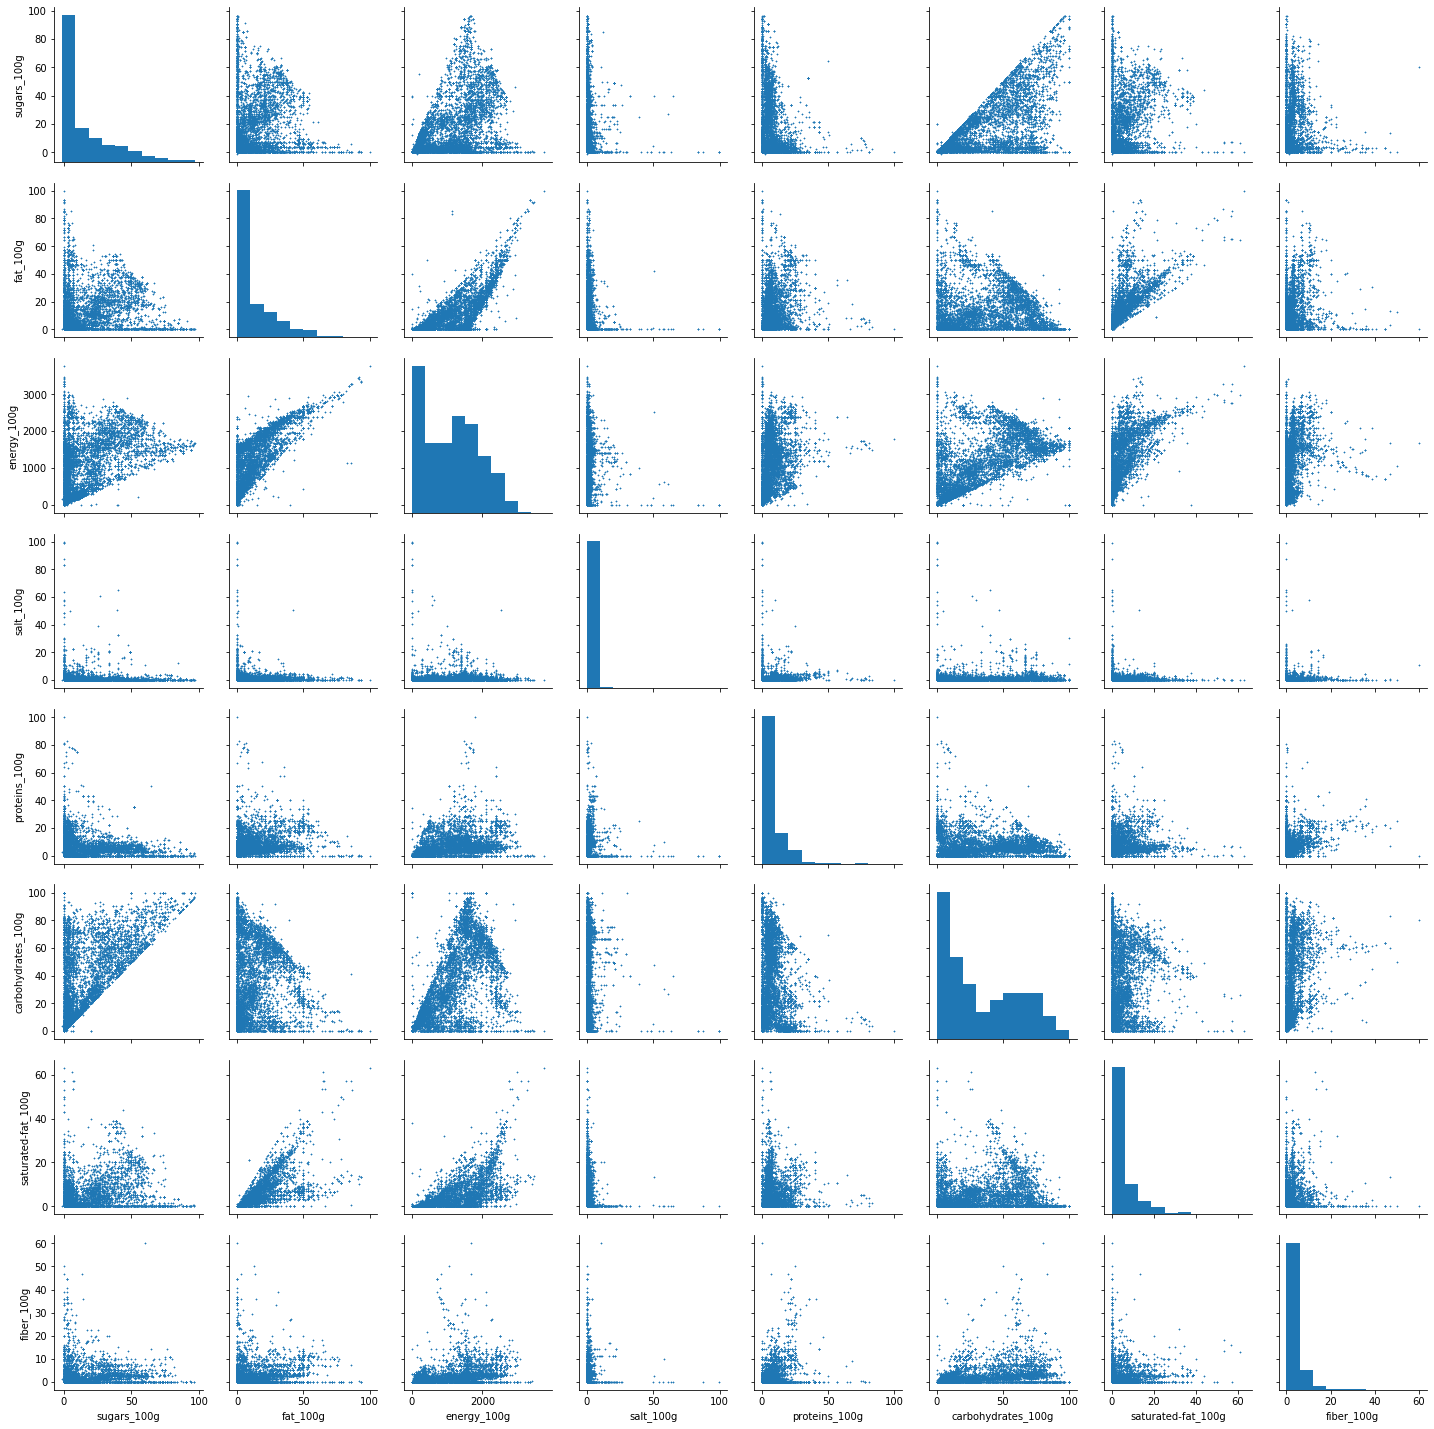

In [33]:
sns.pairplot( \
             sub[['sugars_100g', 'fat_100g', 'energy_100g', 'salt_100g', 'proteins_100g', 'carbohydrates_100g', 'saturated-fat_100g', 'fiber_100g']] \
             , markers="+", plot_kws=dict(s=5));